# Download packages

In [1]:
!pip3 install gdown -q
!pip3 install polars -q
!pip3 install numba -q

# Imports

In [2]:
import gdown
import numpy as np
import pandas as pd
import polars as pl
from tqdm import tqdm
import matplotlib.pyplot as plt
import numba as nb
from numba import njit

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Download data

In [3]:
url = "https://drive.google.com/file/d/1yxGjfJhiu8UKVHgcdvmT2PP6GVHj7Bq5/view?usp=sharing"
output = 'book.parquet'
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1LPYCG_p6n_mES0XqHk4Vg0CzYBxWE-Jw/view?usp=sharing"
output = "book_spot.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1xeFESdzvb8ZQTeQMo9br3UJsdRifj5k3/view?usp=sharing"
output = "ticker.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1Lg-TV1UPp6WKODvoQprhKIQjHiHRq9nG/view?usp=sharing"
output = "ticker_spot.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1cD2OvKGqIHInob2h30bVpW-iulZbaZzg/view?usp=sharing"
output = "trades.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1wMwTD_9UcBwwI-__E0ejBOq4cQurmsYq/view?usp=sharing"
output = "trades_spot.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

url = "https://drive.google.com/file/d/1jZ5Kr5gsX9-deLCzJYCq2T6mbBVRm29f/view?usp=sharing"
output = "target1.parquet"
gdown.download(url=url, output=output, fuzzy=True, quiet=True)

'target1.parquet'

# Data Preparation

In [3]:
book = pl.read_parquet('book.parquet')
ticker = pl.read_parquet('ticker.parquet')
trades = pl.read_parquet('trades.parquet')
target = pl.read_parquet('target1.parquet')
book_spot = pl.read_parquet('book_spot.parquet')
ticker_spot = pl.read_parquet('ticker_spot.parquet')
trades_spot = pl.read_parquet('trades_spot.parquet')

In [4]:
ticker.drop_in_place('remote_ts')
ticker.drop_in_place('remote_ts2')
ticker.drop_in_place('seq')

ticker_spot.drop_in_place('seq')

ticker.head(), ticker_spot.head()

(shape: (5, 5)
 ┌─────────────────────┬───────────┬────────────┬───────────┬────────────┐
 │ local_ts            ┆ bid_price ┆ bid_amount ┆ ask_price ┆ ask_amount │
 │ ---                 ┆ ---       ┆ ---        ┆ ---       ┆ ---        │
 │ i64                 ┆ f64       ┆ f64        ┆ f64       ┆ f64        │
 ╞═════════════════════╪═══════════╪════════════╪═══════════╪════════════╡
 │ 1679443200002269696 ┆ 28091.1   ┆ 0.885      ┆ 28091.2   ┆ 17.243     │
 │ 1679443200023076352 ┆ 28091.1   ┆ 0.685      ┆ 28091.2   ┆ 17.243     │
 │ 1679443200025819392 ┆ 28091.1   ┆ 0.685      ┆ 28091.2   ┆ 17.223     │
 │ 1679443200041581312 ┆ 28091.1   ┆ 0.686      ┆ 28091.2   ┆ 17.223     │
 │ 1679443200045155072 ┆ 28091.1   ┆ 0.686      ┆ 28091.2   ┆ 16.635     │
 └─────────────────────┴───────────┴────────────┴───────────┴────────────┘,
 shape: (5, 5)
 ┌─────────────────────┬───────────┬────────────┬───────────┬────────────┐
 │ local_ts            ┆ bid_price ┆ bid_amount ┆ ask_price ┆ ask_amo

In [5]:
book.drop_in_place('exchange')
book.drop_in_place('symbol')
book.drop_in_place('timestamp')
book = book.sort('local_timestamp')
book = book.rename({'local_timestamp': 'local_ts'})

book_spot.drop_in_place('exchange')
book_spot.drop_in_place('symbol')
book_spot.drop_in_place('timestamp')
book_spot = book_spot.sort('local_timestamp')
book_spot = book_spot.rename({'local_timestamp': 'local_ts'})

book.head(), book_spot.head()

(shape: (5, 101)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ local_ts  ┆ asks[0].p ┆ asks[0].a ┆ bids[0].p ┆ … ┆ asks[24]. ┆ asks[24]. ┆ bids[24]. ┆ bids[24] │
 │ ---       ┆ rice      ┆ mount     ┆ rice      ┆   ┆ price     ┆ amount    ┆ price     ┆ .amount  │
 │ i64       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │           ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 167944320 ┆ 28091.2   ┆ 16.183    ┆ 28091.1   ┆ … ┆ 28093.7   ┆ 0.001     ┆ 28087.6   ┆ 0.002    │
 │ 048513126 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
 │ 4         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
 │ 167944320 ┆ 28090.9   ┆ 6.995     ┆ 28090.8   ┆ … ┆ 28093.5   

In [6]:
trades.drop_in_place('seq')
trades.drop_in_place('remote_ts')
trades.drop_in_place('remote_ts2')
trades = trades.with_columns(pl.col('side').map_dict({"S": -1, "B":1}))

trades_spot.drop_in_place('seq')
trades_spot.drop_in_place('remote_ts')
trades_spot.drop_in_place('remote_ts2')
trades_spot = trades_spot.with_columns(pl.col('side').map_dict({"S": -1, "B":1}))

trades.head(), trades_spot.head()

(shape: (5, 4)
 ┌─────────────────────┬─────────┬────────┬──────┐
 │ local_ts            ┆ price   ┆ amount ┆ side │
 │ ---                 ┆ ---     ┆ ---    ┆ ---  │
 │ i64                 ┆ f64     ┆ f64    ┆ i64  │
 ╞═════════════════════╪═════════╪════════╪══════╡
 │ 1679443200000453376 ┆ 28091.1 ┆ 0.001  ┆ -1   │
 │ 1679443200001720832 ┆ 28091.1 ┆ 0.003  ┆ -1   │
 │ 1679443200022432256 ┆ 28091.1 ┆ 0.007  ┆ -1   │
 │ 1679443200022432406 ┆ 28091.1 ┆ 0.001  ┆ -1   │
 │ 1679443200022597888 ┆ 28091.1 ┆ 0.004  ┆ -1   │
 └─────────────────────┴─────────┴────────┴──────┘,
 shape: (5, 4)
 ┌─────────────────────┬──────────┬─────────┬──────┐
 │ local_ts            ┆ price    ┆ amount  ┆ side │
 │ ---                 ┆ ---      ┆ ---     ┆ ---  │
 │ i64                 ┆ f64      ┆ f64     ┆ i64  │
 ╞═════════════════════╪══════════╪═════════╪══════╡
 │ 1679443200001911808 ┆ 28106.49 ┆ 0.00147 ┆ -1   │
 │ 1679443200002407168 ┆ 28105.48 ┆ 0.00161 ┆ -1   │
 │ 1679443200002408013 ┆ 28105.47 ┆ 0

# Feature generation

### Order book imbalance

In [7]:
ticker = ticker.set_sorted('local_ts').with_columns(
    pl.from_epoch(pl.col("local_ts"), time_unit="ns"))

# ticker_spot = ticker_spot.set_sorted('local_ts').with_columns(
#     pl.from_epoch(pl.col("local_ts"), time_unit="ns"))

In [8]:
ticker = ticker.with_columns(((pl.col('bid_amount') - pl.col('ask_amount')) / 
                              (pl.col('bid_amount') + pl.col('ask_amount'))).alias('imbalance'))
# ticker_spot = ticker_spot.with_columns(((pl.col('bid_amount') - pl.col('ask_amount')) / 
#                               (pl.col('bid_amount') + pl.col('ask_amount'))).alias('imbalance'))

### Improved order book imbalances

In [9]:
@njit
def compute_imbalances(ask_prices, ask_amounts, bid_prices, bid_amounts):
    ask_eligible = [ask_amounts[i] for i, v in enumerate(ask_prices) \
                    if v < (ask_prices[0] * 1.05)]
    median_index = len(ask_eligible) // 2
    if len(ask_eligible) % 2:
        ask_median = ask_eligible[median_index]
    else:
        ask_median = (ask_eligible[median_index] + ask_eligible[median_index - 1]) / 2
    
    bid_eligible = [bid_amounts[i] for i, v in enumerate(bid_prices) \
                    if v > (bid_prices[0] * 0.95)]
    median_index = len(bid_eligible) // 2
    if len(bid_eligible) % 2:
        bid_median = bid_eligible[median_index]
    else:
        bid_median = (bid_eligible[median_index] + bid_eligible[median_index - 1]) / 2

    median = (ask_median + bid_median) / 2

    size = median
    money = 0
    for i, amount in enumerate(ask_amounts):
        if np.isclose(size, 0):
            break
        else:
            if amount < size:
                size -= amount
                money += ask_prices[i] * amount
            else:
                money += ask_prices[i] * size
                size = 0
    ask_imbalance = ((money / median) / ask_prices[0] - 1) * 10**5

    size = median
    money = 0
    for i, amount in enumerate(bid_amounts):
        if np.isclose(size, 0):
            break
        else:
            if amount < size:
                size -= amount
                money += bid_prices[i] * amount
            else:
                money += bid_prices[i] * size
                size = 0
                
    bid_imbalance = (bid_prices[0] / (money / median) - 1) * 10**5

    return (ask_imbalance, bid_imbalance)

@njit
def compute_improved_imbalance(ob_snapshot):
    ts, data = ob_snapshot[0], ob_snapshot[1:]
    ask_prices = data[::4]
    ask_amounts = data[1::4]
    bid_prices = data[2::4]
    bid_amounts = data[3::4]
    ask_imbalance, bid_imbalance = compute_imbalances(ask_prices, ask_amounts, 
                                                        bid_prices, bid_amounts)
    
    return (ts, ask_imbalance, bid_imbalance)

@njit
def numba_imb(dataset):
    tuples = [(0, 0.0, 0.0)] * dataset.shape[0]
    
    for i, row in enumerate(dataset):
        tuples[i] = compute_improved_imbalance(row)
    
    return tuples

In [10]:
tuples = numba_imb(book.to_numpy())
    
improved_imbalance = pl.DataFrame(data=np.array(tuples)).rename(
    {'column_0': 'local_ts', 'column_1': 'imbalance_ask', 'column_2': 'imbalance_bid'}
).with_columns(pl.from_epoch(pl.col("local_ts"), time_unit="ns")).set_sorted('local_ts')

  0%|          | 0/6403491 [00:00<?, ?it/s]

In [11]:
#tuples = numba_imb(book_spot.to_numpy())

# improved_imbalance_spot = pl.DataFrame(data=np.array(tuples)).rename(
#     {'column_0': 'local_ts', 'column_1': 'imbalance_ask', 'column_2': 'imbalance_bid'}
# ).with_columns(pl.from_epoch(pl.col("local_ts"), time_unit="ns")).set_sorted('local_ts')

### Trade imbalance

In [12]:
trades = trades.set_sorted('local_ts').with_columns(
    pl.from_epoch(pl.col("local_ts"), time_unit="ns"))

trades_spot = trades_spot.set_sorted('local_ts').with_columns(
    pl.from_epoch(pl.col("local_ts"), time_unit="ns"))

In [13]:
trades_windows = [500] #[100, 250, 500, 1000, 2000] # in ms

for window in tqdm(trades_windows):
    trades = trades.with_columns(pl.col("side").rolling_sum(
        window_size=f"{window}ms", by="local_ts", closed="right").alias(
        f"trade_imbalance_{window}ms"))

# for window in tqdm(trades_windows):
#     trades_spot = trades_spot.with_columns(pl.col("side").rolling_sum(
#         window_size=f"{window}ms", by="local_ts", closed="right").alias(
#         f"trade_imbalance_{window}ms"))

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]


### Past Returns

In [14]:
@njit
def calculate_past_returns(trades_avg, delta):
    past_returns = [0.0 for i in range(trades_avg.shape[0])]
    
    start_index = 0
    delta_ms = delta * 10**6
    
    for i, v in enumerate(trades_avg):
        while (v[0] - trades_avg[start_index][0]) > delta_ms:
            start_index += 1

        past_returns[i] = (v[1] / trades_avg[start_index][1] - 1) * 10**5
    
    return past_returns

In [15]:
past_returns_window = 50 # in ms

averaged_trades = trades.with_columns(
    ((pl.col('amount') * pl.col('price')).rolling_sum(
        window_size=f"{past_returns_window}ms", by="local_ts", 
        closed="right") / pl.col('amount').rolling_sum(
        window_size=f"{past_returns_window}ms", by="local_ts", 
        closed="right")).alias(f"averaged_{past_returns_window}ms")).select(
    ["local_ts", f"averaged_{past_returns_window}ms"])

averaged_trades_numpy = averaged_trades.with_columns(
    pl.col('local_ts').dt.timestamp('ns')).to_numpy()

averaged_trades_spot = trades_spot.with_columns(
    ((pl.col('amount') * pl.col('price')).rolling_sum(
        window_size=f"{past_returns_window}ms", by="local_ts", 
        closed="right") / pl.col('amount').rolling_sum(
        window_size=f"{past_returns_window}ms", by="local_ts", 
        closed="right")).alias(f"averaged_{past_returns_window}ms")).select(
    ["local_ts", f"averaged_{past_returns_window}ms"])

# averaged_trades_spot_numpy = averaged_trades_spot.with_columns(
#     pl.col('local_ts').dt.timestamp('ns')).to_numpy()

trades_windows = [500] #[100, 250, 500, 1000, 2000]

past_returns_array = []
for window in tqdm(trades_windows):
    past_returns_array.append(calculate_past_returns(averaged_trades_numpy, window))

# past_returns_spot_array = []
# for window in tqdm(trades_windows):
#     past_returns_spot_array.append(calculate_past_returns(averaged_trades_spot_numpy, window))

100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


In [16]:
trades = trades.with_columns(
    [pl.Series(past_returns_array[i]).alias(
        f"past_returns_{window}ms") for i, window in enumerate(trades_windows)])
# trades_spot = trades_spot.with_columns(
#     [pl.Series(past_returns_spot_array[i]).alias(
#         f"past_returns_{window}ms") for i, window in enumerate(trades_windows)])

### Mean divergence

In [17]:
joined_trades_avg = averaged_trades.join_asof(
    averaged_trades_spot, on='local_ts', strategy='backward')
joined_trades_avg = joined_trades_avg.with_columns(
    div=(pl.col('averaged_50ms') / pl.col('averaged_50ms_right') - 1) * 10**5).fill_null(0)

In [18]:
mean_divergence_window = 250 # ms

joined_trades_avg = joined_trades_avg.with_columns(
    (pl.col('div') - pl.col('div').rolling_mean(
        window_size=f"{mean_divergence_window}ms", by='local_ts', 
        closed='right')).alias('mean_div'))

In [19]:
trades = trades.with_columns(mean_div=joined_trades_avg['mean_div'])

### Log-returns

In [20]:
trades = trades.with_columns(
    pl.col('price').log().diff().fill_null(0).alias('log_return'))
# trades_spot = trades_spot.with_columns(
#     pl.col('price').log().diff().fill_null(0).alias('log_return'))

### Autocorrelation

In [21]:
#trades_log_returns = trades.select(['local_ts', 'log_return'])
# trades_spot_log_returns = trades_spot.select(['local_ts', 'log_return'])

autocorrelation_time_window = 10**5 # ms

In [22]:
trades_log_returns = trades.select(['local_ts', 'log_return']).with_columns(
    pl.col('local_ts').dt.timestamp('ns')).to_numpy()

# trades_spot_log_returns = trades_spot.select(['local_ts', 'log_return']).with_columns(
#     pl.col('local_ts').dt.timestamp('ns')).to_numpy()

In [23]:
autocorrelation_time_window = 10**5 # ms

@njit
def shift(xs, n):
    e = np.empty_like(xs, np.float64)
    e[:n] = 0.0
    e[n:] = xs[:-n]
    return e

@njit
def data_autocorrelation(time_series, 
                         lags, 
                         time_window):
    autocorrelations = [[0.0 for i in range(time_series.shape[0])] for j in lags]
    ts = time_series[:, 0]
    prices = time_series[:, 1]
    lag_prices_prod = [np.cumsum(prices * shift(prices, lag)) for lag in lags]

    cum_prices = np.cumsum(prices)
    cum_prices_2 = np.cumsum(prices**2)
    
    start_index = 0
    delta_ms = time_window * 10**6
    
    for i, v in enumerate(ts):
        while (v - ts[start_index]) > delta_ms:
            start_index += 1
        
        for j, lag in enumerate(lags):
            n = i - start_index + 1 - lag
            if n <= 1 or start_index == 0:
                autocorrelations[j][i] = 0
            else:
                sum_x_2 = cum_prices_2[i] - cum_prices_2[start_index + lag - 1]
                sum_x = cum_prices[i] - cum_prices[start_index + lag - 1]
                sum_y_2 = cum_prices_2[i - lag] - cum_prices_2[start_index - 1]
                sum_y = cum_prices[i - lag] - cum_prices[start_index - 1]
                denominator = (n * sum_x_2 - sum_x**2) * (n * sum_y_2 - sum_y**2)
                
                sum_xy = lag_prices_prod[j][i] - lag_prices_prod[j][start_index + lag - 1]
                numerator = n * sum_xy - sum_x * sum_y
                
                if np.isclose(numerator, 0):
                    autocorrelations[j][i] = 0
                elif denominator > 0:
                    autocorrelations[j][i] = np.divide(numerator, np.sqrt(denominator))
                else:
                    autocorrelations[j][i] = 0
                
    
    return autocorrelations

In [24]:
lags = np.array([1])
autocorrelations_per_lag = []
# autocorrelations_spot_per_lag = []

autocorrelations_per_lag = data_autocorrelation(
    trades_log_returns, lags, autocorrelation_time_window)

#autocorrelations_spot_per_lag = data_autocorrelation(
#   trades_spot_log_returns, lags, autocorrelation_time_window)

  0%|          | 0/20548912 [00:00<?, ?it/s]

In [25]:
trades = trades.with_columns([pl.Series(autocorrelations_per_lag[i]).alias(
    f"auto_corr{v}lag").clip(-1, 1) for i, v in enumerate(lags)])

# trades_spot = trades_spot.with_columns([pl.Series(autocorrelations_spot_per_lag[i]).alias(
#     f"auto_corr{v}lag").clip(-1, 1) for i, v in enumerate(lags)])

### Cointegration based on Engle-Granger test

### Realized volatility

In [26]:
realized_volatility_time_window = 10**3 # ms

In [27]:
trades = trades.with_columns(pl.col('log_return').pow(2).rolling_sum(
    window_size=f"{realized_volatility_time_window}ms", by="local_ts", closed="right"
).pow(0.5).fill_nan(0).alias('realized_volatility'))

# trades_spot = trades_spot.with_columns(pl.col('log_return').pow(2).rolling_sum(
#     window_size=f"{realized_volatility_time_window}ms", by="local_ts", closed="right"
# ).pow(0.5).fill_nan(0).alias('realized_volatility'))

### Realized kernel

In [28]:
realized_kernel_time_window = 10**5 # ms

@njit
def shift(xs, n):
    if n == 0:
        return xs.copy()
    e = np.empty_like(xs, np.float64)
    e[:n] = 0.0
    e[n:] = xs[:-n]
    return e

@njit
def parzen_kernel(x):
    x = abs(x)
    if x >= 1:
        return 0
    elif x >= 0.5:
        return 2 * (1 - x)**3
    else:
        return 1 - 6 * x**2 * (1 - x)

@njit
def data_realized_kernel(time_series, 
                         H, 
                         time_window):

    autocorrelations = [0.0 for l in range(time_series.shape[0])]
    
    ts = time_series[:, 0]
    prices = time_series[:, 1]
    
    lag_prices_prod = [np.cumsum(prices * shift(prices, lag)) for lag in range(H+1)]
    kernel_values = [parzen_kernel(k / H) for k in range(1, H + 1)]

    start_index = 0
    delta_ms = time_window * 10**6

    for i, v in enumerate(ts):
        while (v - ts[start_index]) > delta_ms:
            start_index += 1
        
        if start_index == 0:
            autocorrelations[i] = 0
        else:
            kernel_range = min(i + 1 - start_index, H)
            res = lag_prices_prod[0][i] - lag_prices_prod[0][start_index - 1]
            for j in range(1, kernel_range+1):
                res += 2 * kernel_values[j - 1] * (lag_prices_prod[j][i] - \
                                            lag_prices_prod[j][start_index + j - 1])
            autocorrelations[i] = res
    
    return autocorrelations

In [29]:
H = 3
realized_kernel_per_H = []
# realized_kernel_spot_per_H = []

realized_kernel_per_H = data_realized_kernel(
    trades_log_returns, H, realized_kernel_time_window)

# with ProgressBar(total=len(trades_spot_log_returns)) as numba_progress:
#     realized_kernel_spot_per_H = data_realized_kernel(
#         trades_spot_log_returns, H, realized_kernel_time_window, numba_progress)

  0%|          | 0/20548912 [00:00<?, ?it/s]

In [30]:
trades = trades.with_columns(pl.Series(
    realized_kernel_per_H).alias(f"real_kernel_H{H}"))

# trades_spot = trades_spot.with_columns(pl.Series(
#     realized_kernel_spot_per_H).alias(f"real_kernel_H{H}"))

### Jump variation

In [31]:
jump_variation_time_window = realized_volatility_time_window

In [32]:
trades = trades.with_columns((pl.col('realized_volatility')**2 - np.pi / 2 * 
                    (pl.col('log_return').abs() * pl.col('log_return').abs(
                        ).shift_and_fill(0)).rolling_sum(
                         window_size=f"{jump_variation_time_window}ms", 
                         by="local_ts", closed="right")).alias(
                    'jump_variation').clip_min(0))

# trades_spot = trades_spot.with_columns((pl.col('realized_volatility')**2 - np.pi / 2 * 
#                     (pl.col('log_return').abs() * pl.col('log_return').abs(
#                         ).shift_and_fill(0)).rolling_sum(
#                          window_size=f"{jump_variation_time_window}ms", 
#                          by="local_ts", closed="right")).alias(
#                     'jump_variation').clip_min(0))

### Weighted midprice by orderbook

In [33]:
ticker = ticker.with_columns(midprice_w = (pl.col('ask_price') * pl.col('bid_amount') + 
                     pl.col('bid_price') * pl.col('ask_amount')) / 
                   (pl.col('bid_amount') + pl.col('ask_amount')))

# ticker_spot = ticker_spot.with_columns(midprice_w = (pl.col('ask_price') * pl.col('bid_amount') + 
#                      pl.col('bid_price') * pl.col('ask_amount')) / 
#                    (pl.col('bid_amount') + pl.col('ask_amount')))

### Bid-ask spread

In [34]:
ticker = ticker.with_columns((pl.col('ask_price') - pl.col('bid_price')).alias('spread'))
# ticker_spot = ticker_spot.with_columns((pl.col('ask_price') - pl.col('bid_price')).alias('spread'))

### Norm bid-ask spread

In [35]:
tick_size = 0.1
# tick_size_spot = 0.01

ticker = ticker.with_columns(norm_spread=pl.col('spread') / tick_size)
# ticker_spot = ticker_spot.with_columns(norm_spread=pl.col('spread') / tick_size_spot)

# Collecting Dataset

### a little bit truncate dataset due to some features depend on previous data.

In [36]:
features = ticker.drop(['bid_price', 'bid_amount', 'ask_price', 
                        'ask_amount']).join_asof(trades.drop(['price', 
                        'amount', 'side']), on='local_ts', strategy='backward')

features = features.join_asof(improved_imbalance, on='local_ts', strategy='backward')

# features = features.join_asof(ticker_spot.drop(['bid_price', 'bid_amount', 'ask_price', 
#                         'ask_amount']), on='local_ts', strategy='backward')

# features = features.join_asof(trades_spot.drop(['price', 
#                         'amount', 'side']), on='local_ts', strategy='backward')

#features = features.join_asof(improved_imbalance_spot, on='local_ts', strategy='backward')

features = features.with_columns(pl.col('local_ts').dt.timestamp('ns'))
start_time = features['local_ts'][0]
features = features.filter(pl.col('local_ts') > start_time + 10**11)
target = target.filter(pl.col('local_ts') > start_time + 10**11)
features = features.drop('local_ts')
target = target.drop('local_ts')

In [39]:
features_names = features.columns

In [41]:
features_names

['imbalance',
 'midprice_w',
 'spread',
 'norm_spread',
 'trade_imbalance_500ms',
 'past_returns_500ms',
 'mean_div',
 'log_return',
 'auto_corr1lag',
 'realized_volatility',
 'real_kernel_H3',
 'jump_variation',
 'imbalance_ask',
 'imbalance_bid']

In [33]:
@njit
def get_features_correlations(features):
    n_columns = features.shape[1]
    corrs = [0.0 for i in range((n_columns * (n_columns - 1)) // 2)]
    
    feature_means = [np.mean(features[:, i]) for i in range(n_columns)]
    feature_stds = [np.std(features[:, i]) for i in range(n_columns)]
    for i in range(n_columns-1):
        for j in range(i+1, n_columns):
            corr = np.mean(features[:, i] * features[:, j]) - \
            feature_means[i] * feature_means[j]
            
            corr /= feature_stds[i] * feature_stds[j]
            
            corrs[i * n_columns - (i*(i+3) // 2) + j - 1] = corr
    return corrs

In [34]:
corrs = get_features_correlations(features)

In [37]:
pairs = []

for i in range(len(features_names)-1):
    for j in range(i+1, len(features_names)):
        pairs.append(features_names[i] + '|' + features_names[j])

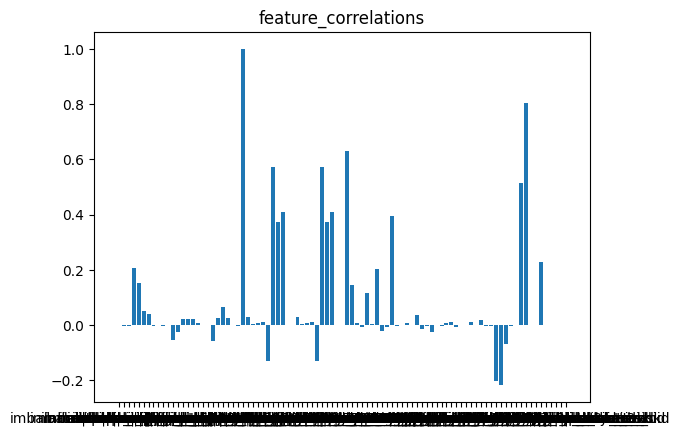

In [42]:
plt.bar(pairs, corrs)
plt.title('feature_correlations')
plt.savefig('feature_correlations.png')
plt.show()